# Autoencoder
512 -> 256 -> 128 -> 256 -> 512

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()


        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)  # 512x512 -> 256x256
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)  # 256x256 -> 128x128

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Downsample to 256x256
        x = F.relu(self.conv2(x))  # Downsample to 128x128
        return x 

In [3]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        
        self.convt1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)  # 128x128 -> 256x256
        self.convt2 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)  # 256x256 -> 512x512

    def forward(self, x):
        x = F.relu(self.convt1(x))  
        x = torch.sigmoid(self.convt2(x))  # Upsample to 512x512
        return x  

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()  # Downsampling: 512x512 -> 128x128
        self.decoder = Decoder()  # Upsampling: 128x128 -> 512x512

    def forward(self, x):
        emb = self.encoder(x)  
        reconstructed = self.decoder(emb)  
        return reconstructed, emb

In [5]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path)  

        if self.transform:
            image = self.transform(image)
        
        return image  


In [6]:
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # Ensure images are grayscale (if not already)
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])


folder_path = 'toys/train'

dataset = ImageDataset(folder_path, transform=transform)
batch_size = 16 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


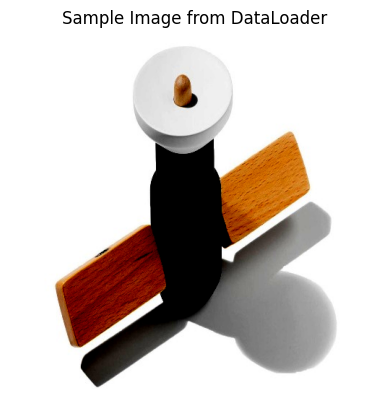

In [10]:
import matplotlib.pyplot as plt

images = next(iter(dataloader))

image = images[7].cpu().numpy().squeeze()
image = image.transpose(1, 2, 0)
plt.imshow(image, cmap='gray')
plt.title("Sample Image from DataLoader")
plt.axis('off')
plt.show()

In [11]:
images.shape

torch.Size([16, 3, 512, 512])

In [12]:
# AutoEncoder model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = AutoEncoder().to(device)


criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0

    for images in dataloader:
        images = images.to(device)  

        reconstructed, _ = autoencoder(images)
        loss = criterion(reconstructed, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/15], Loss: 0.2454
Epoch [2/15], Loss: 0.1434
Epoch [3/15], Loss: 0.1275
Epoch [4/15], Loss: 0.1243
Epoch [5/15], Loss: 0.1223
Epoch [6/15], Loss: 0.1218
Epoch [7/15], Loss: 0.1205
Epoch [8/15], Loss: 0.1214
Epoch [9/15], Loss: 0.1200
Epoch [10/15], Loss: 0.1199
Epoch [11/15], Loss: 0.1190
Epoch [12/15], Loss: 0.1191
Epoch [13/15], Loss: 0.1193
Epoch [14/15], Loss: 0.1207
Epoch [15/15], Loss: 0.1183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


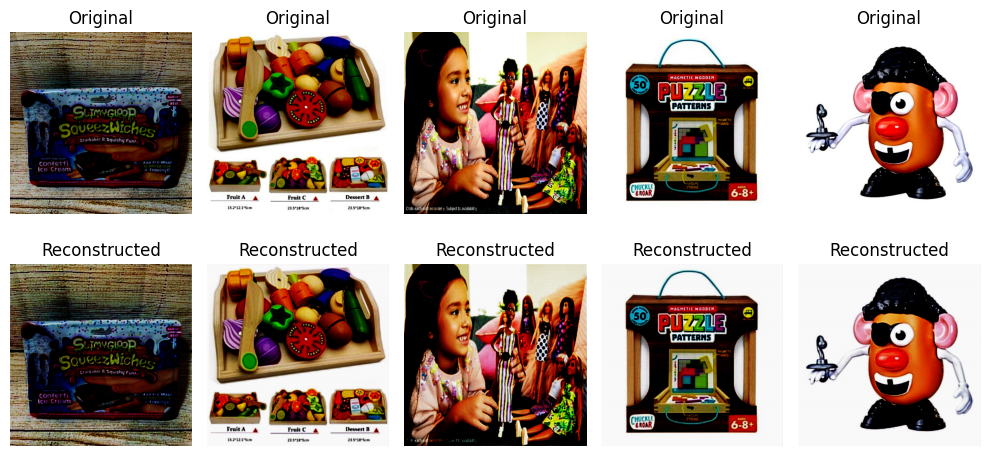

In [ ]:
import matplotlib.pyplot as plt
autoencoder.eval()
images = next(iter(dataloader))
images = images.to(device)

with torch.no_grad():
    reconstructed, _ = autoencoder(images)

images = images.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(5): 
    # Original image
    plt.subplot(2, 5, i + 1)
    # images[i] = images[i].transpose(1, 2, 0)
    plt.imshow(images[i].squeeze().transpose(1, 2, 0))
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, 5, i + 6)
    # reconstructed[i] = reconstructed[i].transpose(1, 2, 0)
    plt.imshow(reconstructed[i].squeeze().transpose(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis('off')

    # print(images[i] - reconstructed[i])

plt.tight_layout()
plt.show()


In [20]:
# Calculate reconstruction loss on the test dataset
autoencoder.eval()
total_loss = 0

folder_path = 'toys/test'

dataset_test = ImageDataset(folder_path, transform=transform)

batch_size = 16 
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
with torch.no_grad():
    for images in dataloader_test:  
        images = images.to(device)
        reconstructed, _ = autoencoder(images)
        loss = nn.MSELoss()(reconstructed, images)
        total_loss += loss.item()

average_loss = total_loss / len(dataloader_test)
print(f"Reconstruction Loss (MSE): {average_loss:.4f}")


Reconstruction Loss (MSE): 0.1377


In [10]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Function to test the autoencoder on a random image
def test_autoencoder_on_image(image_path, autoencoder, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')  
    preprocess = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize to 512x512
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])
    
    input_image = preprocess(image).unsqueeze(0).to(device)  
    
    autoencoder.eval() 
    with torch.no_grad():
        out_128, out_256, reconstructed_image, _ = autoencoder(input_image)
    
    input_image = input_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    # input_image = (input_image * 0.5) + 0.5
    # reconstructed_image = (reconstructed_image * 0.5) + 0.5

    # Plot the original and reconstructed images
    plt.figure(figsize=(8, 4))
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title("Original Image")
    plt.axis('off')
    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image)
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_7567/2475010591.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_mrl = torch.load("weights/update_ae_50.pth")
Clipping input data to the valid 

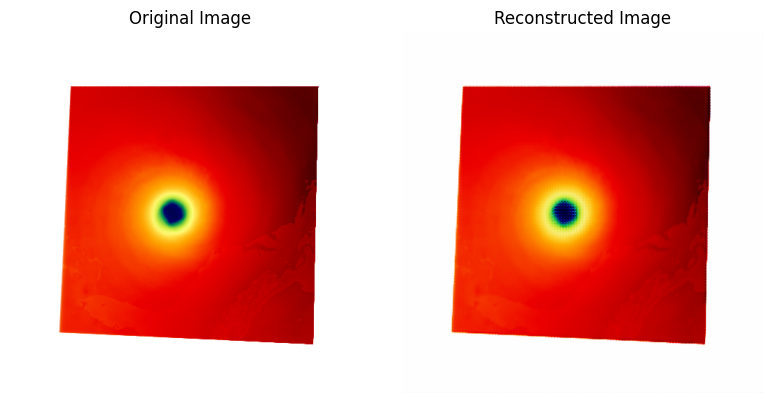

In [11]:
image_path = '/home/hardik/Desktop/ugp/data/test/512/-1.0000_6.0000.png'
from autoencoder import AutoEncoderMRL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder_mrl = AutoEncoderMRL().to(device)
autoencoder_mrl = torch.load("weights/update_ae_50.pth")
autoencoder_mrl.eval()
# autoencoder = autoencoder.to(device)
test_autoencoder_on_image(image_path, autoencoder_mrl, device)
